In [37]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from src.preprocess import preprocess_folder
from src.format_data import create_dataset
from src.model import create_embedding_model, create_flux_model
from src.losses import get_companion_std, keep_back

from tensorflow.keras.optimizers import Adam
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
cube, psf, rot_angles, table = preprocess_folder(root='./data/fake', 
												 target_folder='./data/fake/preprocessed')

table = table[table['snr'] > 1]

window_size = 30
dataset = create_dataset(cube, psf, rot_angles, table, window_size=window_size,
                         batch_size=2000, repeat=2)

model = create_embedding_model(window_size=window_size)

optimizer = Adam(1e-5)
model.compile(loss_fn=keep_back, optimizer=optimizer)

es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=1e-4,
        patience=50,
        mode='min',
        restore_best_weights=True,
    )

[INFO] Restoring saved values


In [39]:
# model.summary()
table = table[table['snr'] >3]
table

,x,y,flux,fwhm_mean,snr
0,386.000008,727.508451,137.76877,4.946172,80.595763


In [40]:
%%time
hist = model.fit(dataset, epochs=10000, callbacks=[es])

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: 13.6793
Epoch 2/10000
1/1 [==============================] - 0s 253ms/step - loss: 13.6793
Epoch 3/10000
1/1 [==============================] - 0s 220ms/step - loss: 13.6792
Epoch 4/10000
1/1 [==============================] - 0s 252ms/step - loss: 13.6792
Epoch 5/10000
1/1 [==============================] - 0s 253ms/step - loss: 13.6791
Epoch 6/10000
1/1 [==============================] - 0s 233ms/step - loss: 13.6791
Epoch 7/10000
1/1 [==============================] - 0s 227ms/step - loss: 13.6791
Epoch 8/10000
1/1 [==============================] - 0s 266ms/step - loss: 13.6790
Epoch 9/10000
1/1 [==============================] - 0s 263ms/step - loss: 13.6790
Epoch 10/10000
1/1 [==============================] - 0s 263ms/step - loss: 13.6789
Epoch 11/10000
1/1 [==============================] - 0s 272ms/step - loss: 13.6789
Epoch 12/10000
1/1 [==============================] - 0s 241ms/step - loss: 13.6788
Epoc

1/1 [==============================] - 0s 301ms/step - loss: 13.6713
Epoch 99/10000
1/1 [==============================] - 0s 280ms/step - loss: 13.6711
Epoch 100/10000
1/1 [==============================] - 0s 319ms/step - loss: 13.6709
Epoch 101/10000
1/1 [==============================] - 0s 298ms/step - loss: 13.6708
Epoch 102/10000
1/1 [==============================] - 0s 270ms/step - loss: 13.6706
Epoch 103/10000
1/1 [==============================] - 0s 270ms/step - loss: 13.6704
Epoch 104/10000
1/1 [==============================] - 0s 308ms/step - loss: 13.6702
Epoch 105/10000
1/1 [==============================] - 0s 288ms/step - loss: 13.6700
Epoch 106/10000
1/1 [==============================] - 0s 307ms/step - loss: 13.6698
Epoch 107/10000
1/1 [==============================] - 0s 328ms/step - loss: 13.6696
Epoch 108/10000
1/1 [==============================] - 0s 303ms/step - loss: 13.6694
Epoch 109/10000
1/1 [==============================] - 0s 261ms/step - loss: 13.66

1/1 [==============================] - 0s 342ms/step - loss: 13.6327
Epoch 195/10000
1/1 [==============================] - 0s 277ms/step - loss: 13.6320
Epoch 196/10000
1/1 [==============================] - 0s 261ms/step - loss: 13.6313
Epoch 197/10000
1/1 [==============================] - 0s 340ms/step - loss: 13.6305
Epoch 198/10000
1/1 [==============================] - 0s 281ms/step - loss: 13.6298
Epoch 199/10000
1/1 [==============================] - 0s 288ms/step - loss: 13.6290
Epoch 200/10000
1/1 [==============================] - 0s 327ms/step - loss: 13.6283
Epoch 201/10000
1/1 [==============================] - 0s 280ms/step - loss: 13.6275
Epoch 202/10000
1/1 [==============================] - 0s 301ms/step - loss: 13.6267
Epoch 203/10000
1/1 [==============================] - 0s 277ms/step - loss: 13.6259
Epoch 204/10000
1/1 [==============================] - 0s 286ms/step - loss: 13.6252
Epoch 205/10000
1/1 [==============================] - 0s 300ms/step - loss: 13.6

1/1 [==============================] - 0s 296ms/step - loss: 13.5225
Epoch 291/10000
1/1 [==============================] - 0s 212ms/step - loss: 13.5209
Epoch 292/10000
1/1 [==============================] - 0s 276ms/step - loss: 13.5193
Epoch 293/10000
1/1 [==============================] - 0s 267ms/step - loss: 13.5177
Epoch 294/10000
1/1 [==============================] - 0s 263ms/step - loss: 13.5161
Epoch 295/10000
1/1 [==============================] - 0s 308ms/step - loss: 13.5145
Epoch 296/10000
1/1 [==============================] - 0s 317ms/step - loss: 13.5128
Epoch 297/10000
1/1 [==============================] - 0s 286ms/step - loss: 13.5112
Epoch 298/10000
1/1 [==============================] - 0s 298ms/step - loss: 13.5095
Epoch 299/10000
1/1 [==============================] - 0s 308ms/step - loss: 13.5078
Epoch 300/10000
1/1 [==============================] - 0s 311ms/step - loss: 13.5061
Epoch 301/10000
1/1 [==============================] - 0s 319ms/step - loss: 13.5

1/1 [==============================] - 0s 279ms/step - loss: 13.3362
Epoch 387/10000
1/1 [==============================] - 0s 274ms/step - loss: 13.3340
Epoch 388/10000
1/1 [==============================] - 0s 289ms/step - loss: 13.3319
Epoch 389/10000
1/1 [==============================] - 0s 294ms/step - loss: 13.3297
Epoch 390/10000
1/1 [==============================] - 0s 248ms/step - loss: 13.3275
Epoch 391/10000
1/1 [==============================] - 0s 291ms/step - loss: 13.3253
Epoch 392/10000
1/1 [==============================] - 0s 261ms/step - loss: 13.3231
Epoch 393/10000
1/1 [==============================] - 0s 288ms/step - loss: 13.3209
Epoch 394/10000
1/1 [==============================] - 0s 301ms/step - loss: 13.3188
Epoch 395/10000
1/1 [==============================] - 0s 300ms/step - loss: 13.3166
Epoch 396/10000
1/1 [==============================] - 0s 316ms/step - loss: 13.3144
Epoch 397/10000
1/1 [==============================] - 0s 296ms/step - loss: 13.3

1/1 [==============================] - 0s 299ms/step - loss: 13.1265
Epoch 483/10000
1/1 [==============================] - 0s 301ms/step - loss: 13.1244
Epoch 484/10000
1/1 [==============================] - 0s 273ms/step - loss: 13.1222
Epoch 485/10000
1/1 [==============================] - 0s 283ms/step - loss: 13.1201
Epoch 486/10000
1/1 [==============================] - 0s 296ms/step - loss: 13.1180
Epoch 487/10000
1/1 [==============================] - 0s 284ms/step - loss: 13.1159
Epoch 488/10000
1/1 [==============================] - 0s 282ms/step - loss: 13.1138
Epoch 489/10000
1/1 [==============================] - 0s 299ms/step - loss: 13.1117
Epoch 490/10000
1/1 [==============================] - 0s 275ms/step - loss: 13.1095
Epoch 491/10000
1/1 [==============================] - 0s 289ms/step - loss: 13.1074
Epoch 492/10000
1/1 [==============================] - 0s 281ms/step - loss: 13.1053
Epoch 493/10000
1/1 [==============================] - 0s 292ms/step - loss: 13.1

1/1 [==============================] - 0s 318ms/step - loss: 12.9330
Epoch 579/10000
1/1 [==============================] - 0s 297ms/step - loss: 12.9311
Epoch 580/10000
1/1 [==============================] - 0s 258ms/step - loss: 12.9292
Epoch 581/10000
1/1 [==============================] - 0s 307ms/step - loss: 12.9273
Epoch 582/10000
1/1 [==============================] - 0s 323ms/step - loss: 12.9254
Epoch 583/10000
1/1 [==============================] - 0s 284ms/step - loss: 12.9235
Epoch 584/10000
1/1 [==============================] - 0s 282ms/step - loss: 12.9216
Epoch 585/10000
1/1 [==============================] - 0s 261ms/step - loss: 12.9198
Epoch 586/10000
1/1 [==============================] - 0s 278ms/step - loss: 12.9179
Epoch 587/10000
1/1 [==============================] - 0s 257ms/step - loss: 12.9160
Epoch 588/10000
1/1 [==============================] - 0s 279ms/step - loss: 12.9141
Epoch 589/10000
1/1 [==============================] - 0s 310ms/step - loss: 12.9

1/1 [==============================] - 0s 292ms/step - loss: 12.7614
Epoch 675/10000
1/1 [==============================] - 0s 284ms/step - loss: 12.7597
Epoch 676/10000
1/1 [==============================] - 0s 280ms/step - loss: 12.7581
Epoch 677/10000
1/1 [==============================] - 0s 302ms/step - loss: 12.7564
Epoch 678/10000
1/1 [==============================] - 0s 260ms/step - loss: 12.7547
Epoch 679/10000
1/1 [==============================] - 0s 292ms/step - loss: 12.7530
Epoch 680/10000
1/1 [==============================] - 0s 276ms/step - loss: 12.7514
Epoch 681/10000
1/1 [==============================] - 0s 273ms/step - loss: 12.7497
Epoch 682/10000
1/1 [==============================] - 0s 280ms/step - loss: 12.7480
Epoch 683/10000
1/1 [==============================] - 0s 279ms/step - loss: 12.7463
Epoch 684/10000
1/1 [==============================] - 0s 266ms/step - loss: 12.7447
Epoch 685/10000
1/1 [==============================] - 0s 283ms/step - loss: 12.7

1/1 [==============================] - 0s 281ms/step - loss: 12.6085
Epoch 771/10000
1/1 [==============================] - 0s 291ms/step - loss: 12.6070
Epoch 772/10000
1/1 [==============================] - 0s 280ms/step - loss: 12.6055
Epoch 773/10000
1/1 [==============================] - 0s 312ms/step - loss: 12.6039
Epoch 774/10000
1/1 [==============================] - 0s 257ms/step - loss: 12.6024
Epoch 775/10000
1/1 [==============================] - 0s 297ms/step - loss: 12.6009
Epoch 776/10000
1/1 [==============================] - 0s 277ms/step - loss: 12.5994
Epoch 777/10000
1/1 [==============================] - 0s 279ms/step - loss: 12.5979
Epoch 778/10000
1/1 [==============================] - 0s 301ms/step - loss: 12.5964
Epoch 779/10000
1/1 [==============================] - 0s 290ms/step - loss: 12.5949
Epoch 780/10000
1/1 [==============================] - 0s 266ms/step - loss: 12.5934
Epoch 781/10000
1/1 [==============================] - 0s 278ms/step - loss: 12.5

1/1 [==============================] - 0s 303ms/step - loss: 12.4702
Epoch 867/10000
1/1 [==============================] - 0s 268ms/step - loss: 12.4688
Epoch 868/10000
1/1 [==============================] - 0s 273ms/step - loss: 12.4674
Epoch 869/10000
1/1 [==============================] - 0s 284ms/step - loss: 12.4660
Epoch 870/10000
1/1 [==============================] - 0s 292ms/step - loss: 12.4647
Epoch 871/10000
1/1 [==============================] - 0s 288ms/step - loss: 12.4633
Epoch 872/10000
1/1 [==============================] - 0s 270ms/step - loss: 12.4619
Epoch 873/10000
1/1 [==============================] - 0s 307ms/step - loss: 12.4606
Epoch 874/10000
1/1 [==============================] - 0s 255ms/step - loss: 12.4592
Epoch 875/10000
1/1 [==============================] - 0s 310ms/step - loss: 12.4578
Epoch 876/10000
1/1 [==============================] - 0s 298ms/step - loss: 12.4565
Epoch 877/10000
1/1 [==============================] - 0s 291ms/step - loss: 12.4

1/1 [==============================] - 0s 252ms/step - loss: 12.3436
Epoch 963/10000
1/1 [==============================] - 0s 243ms/step - loss: 12.3424
Epoch 964/10000
1/1 [==============================] - 0s 252ms/step - loss: 12.3411
Epoch 965/10000
1/1 [==============================] - 0s 240ms/step - loss: 12.3399
Epoch 966/10000
1/1 [==============================] - 0s 293ms/step - loss: 12.3386
Epoch 967/10000
1/1 [==============================] - 0s 252ms/step - loss: 12.3373
Epoch 968/10000
1/1 [==============================] - 0s 255ms/step - loss: 12.3361
Epoch 969/10000
1/1 [==============================] - 0s 253ms/step - loss: 12.3348
Epoch 970/10000
1/1 [==============================] - 0s 263ms/step - loss: 12.3336
Epoch 971/10000
1/1 [==============================] - 0s 262ms/step - loss: 12.3323
Epoch 972/10000
1/1 [==============================] - 0s 269ms/step - loss: 12.3311
Epoch 973/10000
1/1 [==============================] - 0s 283ms/step - loss: 12.3

1/1 [==============================] - 0s 319ms/step - loss: 12.2283
Epoch 1058/10000
1/1 [==============================] - 0s 264ms/step - loss: 12.2271
Epoch 1059/10000
1/1 [==============================] - 0s 316ms/step - loss: 12.2259
Epoch 1060/10000
1/1 [==============================] - 0s 293ms/step - loss: 12.2248
Epoch 1061/10000
1/1 [==============================] - 0s 292ms/step - loss: 12.2236
Epoch 1062/10000
1/1 [==============================] - 0s 287ms/step - loss: 12.2224
Epoch 1063/10000
1/1 [==============================] - 0s 261ms/step - loss: 12.2213
Epoch 1064/10000
1/1 [==============================] - 0s 273ms/step - loss: 12.2201
Epoch 1065/10000
1/1 [==============================] - 0s 277ms/step - loss: 12.2190
Epoch 1066/10000
1/1 [==============================] - 0s 256ms/step - loss: 12.2178
Epoch 1067/10000
1/1 [==============================] - 0s 272ms/step - loss: 12.2166
Epoch 1068/10000
1/1 [==============================] - 0s 273ms/step -

1/1 [==============================] - 0s 290ms/step - loss: 12.1215
Epoch 1153/10000
1/1 [==============================] - 0s 270ms/step - loss: 12.1204
Epoch 1154/10000
1/1 [==============================] - 0s 298ms/step - loss: 12.1194
Epoch 1155/10000
1/1 [==============================] - 0s 283ms/step - loss: 12.1183
Epoch 1156/10000
1/1 [==============================] - 0s 280ms/step - loss: 12.1172
Epoch 1157/10000
1/1 [==============================] - 0s 297ms/step - loss: 12.1161
Epoch 1158/10000
1/1 [==============================] - 0s 300ms/step - loss: 12.1150
Epoch 1159/10000
1/1 [==============================] - 0s 281ms/step - loss: 12.1140
Epoch 1160/10000
1/1 [==============================] - 0s 286ms/step - loss: 12.1129
Epoch 1161/10000
1/1 [==============================] - 0s 291ms/step - loss: 12.1118
Epoch 1162/10000
1/1 [==============================] - 0s 284ms/step - loss: 12.1107
Epoch 1163/10000
1/1 [==============================] - 0s 293ms/step -

1/1 [==============================] - 0s 286ms/step - loss: 12.0227
Epoch 1248/10000
1/1 [==============================] - 0s 273ms/step - loss: 12.0217
Epoch 1249/10000
1/1 [==============================] - 0s 256ms/step - loss: 12.0207
Epoch 1250/10000
1/1 [==============================] - 0s 275ms/step - loss: 12.0197
Epoch 1251/10000
1/1 [==============================] - 0s 232ms/step - loss: 12.0187
Epoch 1252/10000
1/1 [==============================] - 0s 264ms/step - loss: 12.0177
Epoch 1253/10000
1/1 [==============================] - 0s 263ms/step - loss: 12.0167
Epoch 1254/10000
1/1 [==============================] - 0s 263ms/step - loss: 12.0157
Epoch 1255/10000
1/1 [==============================] - 0s 265ms/step - loss: 12.0147
Epoch 1256/10000
1/1 [==============================] - 0s 241ms/step - loss: 12.0137
Epoch 1257/10000
1/1 [==============================] - 0s 241ms/step - loss: 12.0127
Epoch 1258/10000
1/1 [==============================] - 0s 261ms/step -

1/1 [==============================] - 0s 249ms/step - loss: 11.9312
Epoch 1343/10000
1/1 [==============================] - 0s 262ms/step - loss: 11.9303
Epoch 1344/10000
1/1 [==============================] - 0s 290ms/step - loss: 11.9294
Epoch 1345/10000
1/1 [==============================] - 0s 270ms/step - loss: 11.9285
Epoch 1346/10000
1/1 [==============================] - 0s 309ms/step - loss: 11.9275
Epoch 1347/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.9266
Epoch 1348/10000
1/1 [==============================] - 0s 264ms/step - loss: 11.9257
Epoch 1349/10000
1/1 [==============================] - 0s 266ms/step - loss: 11.9248
Epoch 1350/10000
1/1 [==============================] - 0s 319ms/step - loss: 11.9238
Epoch 1351/10000
1/1 [==============================] - 0s 313ms/step - loss: 11.9229
Epoch 1352/10000
1/1 [==============================] - 0s 299ms/step - loss: 11.9220
Epoch 1353/10000
1/1 [==============================] - 0s 308ms/step -

1/1 [==============================] - 0s 283ms/step - loss: 11.8468
Epoch 1438/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.8460
Epoch 1439/10000
1/1 [==============================] - 0s 298ms/step - loss: 11.8451
Epoch 1440/10000
1/1 [==============================] - 0s 304ms/step - loss: 11.8443
Epoch 1441/10000
1/1 [==============================] - 0s 295ms/step - loss: 11.8434
Epoch 1442/10000
1/1 [==============================] - 0s 275ms/step - loss: 11.8426
Epoch 1443/10000
1/1 [==============================] - 0s 304ms/step - loss: 11.8417
Epoch 1444/10000
1/1 [==============================] - 0s 320ms/step - loss: 11.8409
Epoch 1445/10000
1/1 [==============================] - 0s 301ms/step - loss: 11.8400
Epoch 1446/10000
1/1 [==============================] - 0s 308ms/step - loss: 11.8392
Epoch 1447/10000
1/1 [==============================] - 0s 315ms/step - loss: 11.8383
Epoch 1448/10000
1/1 [==============================] - 0s 284ms/step -

1/1 [==============================] - 0s 274ms/step - loss: 11.7692
Epoch 1533/10000
1/1 [==============================] - 0s 256ms/step - loss: 11.7684
Epoch 1534/10000
1/1 [==============================] - 0s 238ms/step - loss: 11.7676
Epoch 1535/10000
1/1 [==============================] - 0s 276ms/step - loss: 11.7668
Epoch 1536/10000
1/1 [==============================] - 0s 254ms/step - loss: 11.7661
Epoch 1537/10000
1/1 [==============================] - 0s 256ms/step - loss: 11.7653
Epoch 1538/10000
1/1 [==============================] - 0s 257ms/step - loss: 11.7645
Epoch 1539/10000
1/1 [==============================] - 0s 264ms/step - loss: 11.7637
Epoch 1540/10000
1/1 [==============================] - 0s 277ms/step - loss: 11.7630
Epoch 1541/10000
1/1 [==============================] - 0s 306ms/step - loss: 11.7622
Epoch 1542/10000
1/1 [==============================] - 0s 306ms/step - loss: 11.7614
Epoch 1543/10000
1/1 [==============================] - 0s 253ms/step -

1/1 [==============================] - 0s 274ms/step - loss: 11.6981
Epoch 1628/10000
1/1 [==============================] - 0s 274ms/step - loss: 11.6974
Epoch 1629/10000
1/1 [==============================] - 0s 299ms/step - loss: 11.6967
Epoch 1630/10000
1/1 [==============================] - 0s 270ms/step - loss: 11.6960
Epoch 1631/10000
1/1 [==============================] - 0s 265ms/step - loss: 11.6953
Epoch 1632/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.6945
Epoch 1633/10000
1/1 [==============================] - 0s 246ms/step - loss: 11.6938
Epoch 1634/10000
1/1 [==============================] - 0s 310ms/step - loss: 11.6931
Epoch 1635/10000
1/1 [==============================] - 0s 308ms/step - loss: 11.6924
Epoch 1636/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.6917
Epoch 1637/10000
1/1 [==============================] - 0s 269ms/step - loss: 11.6910
Epoch 1638/10000
1/1 [==============================] - 0s 295ms/step -

1/1 [==============================] - 0s 266ms/step - loss: 11.6334
Epoch 1723/10000
1/1 [==============================] - 0s 285ms/step - loss: 11.6327
Epoch 1724/10000
1/1 [==============================] - 0s 312ms/step - loss: 11.6321
Epoch 1725/10000
1/1 [==============================] - 0s 278ms/step - loss: 11.6314
Epoch 1726/10000
1/1 [==============================] - 0s 276ms/step - loss: 11.6308
Epoch 1727/10000
1/1 [==============================] - 0s 282ms/step - loss: 11.6301
Epoch 1728/10000
1/1 [==============================] - 0s 268ms/step - loss: 11.6295
Epoch 1729/10000
1/1 [==============================] - 0s 253ms/step - loss: 11.6288
Epoch 1730/10000
1/1 [==============================] - 0s 292ms/step - loss: 11.6282
Epoch 1731/10000
1/1 [==============================] - 0s 322ms/step - loss: 11.6276
Epoch 1732/10000
1/1 [==============================] - 0s 262ms/step - loss: 11.6269
Epoch 1733/10000
1/1 [==============================] - 0s 249ms/step -

1/1 [==============================] - 0s 282ms/step - loss: 11.5748
Epoch 1818/10000
1/1 [==============================] - 0s 282ms/step - loss: 11.5742
Epoch 1819/10000
1/1 [==============================] - 0s 299ms/step - loss: 11.5736
Epoch 1820/10000
1/1 [==============================] - 0s 287ms/step - loss: 11.5730
Epoch 1821/10000
1/1 [==============================] - 0s 315ms/step - loss: 11.5724
Epoch 1822/10000
1/1 [==============================] - 0s 280ms/step - loss: 11.5718
Epoch 1823/10000
1/1 [==============================] - 0s 270ms/step - loss: 11.5713
Epoch 1824/10000
1/1 [==============================] - 0s 286ms/step - loss: 11.5707
Epoch 1825/10000
1/1 [==============================] - 0s 240ms/step - loss: 11.5701
Epoch 1826/10000
1/1 [==============================] - 0s 268ms/step - loss: 11.5695
Epoch 1827/10000
1/1 [==============================] - 0s 297ms/step - loss: 11.5690
Epoch 1828/10000
1/1 [==============================] - 0s 264ms/step -

1/1 [==============================] - 0s 305ms/step - loss: 11.5221
Epoch 1913/10000
1/1 [==============================] - 0s 303ms/step - loss: 11.5216
Epoch 1914/10000
1/1 [==============================] - 0s 294ms/step - loss: 11.5210
Epoch 1915/10000
1/1 [==============================] - 0s 308ms/step - loss: 11.5205
Epoch 1916/10000
1/1 [==============================] - 0s 293ms/step - loss: 11.5200
Epoch 1917/10000
1/1 [==============================] - 0s 282ms/step - loss: 11.5195
Epoch 1918/10000
1/1 [==============================] - 0s 289ms/step - loss: 11.5189
Epoch 1919/10000
1/1 [==============================] - 0s 283ms/step - loss: 11.5184
Epoch 1920/10000
1/1 [==============================] - 0s 278ms/step - loss: 11.5179
Epoch 1921/10000
1/1 [==============================] - 0s 272ms/step - loss: 11.5174
Epoch 1922/10000
1/1 [==============================] - 0s 313ms/step - loss: 11.5169
Epoch 1923/10000
1/1 [==============================] - 0s 290ms/step -

1/1 [==============================] - 0s 250ms/step - loss: 11.4751
Epoch 2008/10000
1/1 [==============================] - 0s 303ms/step - loss: 11.4746
Epoch 2009/10000
1/1 [==============================] - 0s 270ms/step - loss: 11.4741
Epoch 2010/10000
1/1 [==============================] - 0s 318ms/step - loss: 11.4737
Epoch 2011/10000
1/1 [==============================] - 0s 256ms/step - loss: 11.4732
Epoch 2012/10000
1/1 [==============================] - 0s 223ms/step - loss: 11.4728
Epoch 2013/10000
1/1 [==============================] - 0s 261ms/step - loss: 11.4723
Epoch 2014/10000
1/1 [==============================] - 0s 219ms/step - loss: 11.4718
Epoch 2015/10000
1/1 [==============================] - 0s 252ms/step - loss: 11.4714
Epoch 2016/10000
1/1 [==============================] - 0s 242ms/step - loss: 11.4709
Epoch 2017/10000
1/1 [==============================] - 0s 311ms/step - loss: 11.4705
Epoch 2018/10000
1/1 [==============================] - 0s 221ms/step -

1/1 [==============================] - 0s 284ms/step - loss: 11.4335
Epoch 2103/10000
1/1 [==============================] - 0s 302ms/step - loss: 11.4331
Epoch 2104/10000
1/1 [==============================] - 0s 315ms/step - loss: 11.4327
Epoch 2105/10000
1/1 [==============================] - 0s 269ms/step - loss: 11.4323
Epoch 2106/10000
1/1 [==============================] - 0s 280ms/step - loss: 11.4319
Epoch 2107/10000
1/1 [==============================] - 0s 268ms/step - loss: 11.4315
Epoch 2108/10000
1/1 [==============================] - 0s 231ms/step - loss: 11.4311
Epoch 2109/10000
1/1 [==============================] - 0s 285ms/step - loss: 11.4306
Epoch 2110/10000
1/1 [==============================] - 0s 274ms/step - loss: 11.4302
Epoch 2111/10000
1/1 [==============================] - 0s 302ms/step - loss: 11.4298
Epoch 2112/10000
1/1 [==============================] - 0s 275ms/step - loss: 11.4294
Epoch 2113/10000
1/1 [==============================] - 0s 258ms/step -

1/1 [==============================] - 0s 270ms/step - loss: 11.3970
Epoch 2198/10000
1/1 [==============================] - 0s 259ms/step - loss: 11.3967
Epoch 2199/10000
1/1 [==============================] - 0s 286ms/step - loss: 11.3963
Epoch 2200/10000
1/1 [==============================] - 0s 283ms/step - loss: 11.3960
Epoch 2201/10000
1/1 [==============================] - 0s 319ms/step - loss: 11.3956
Epoch 2202/10000
1/1 [==============================] - 0s 306ms/step - loss: 11.3953
Epoch 2203/10000
1/1 [==============================] - 0s 262ms/step - loss: 11.3949
Epoch 2204/10000
1/1 [==============================] - 0s 227ms/step - loss: 11.3946
Epoch 2205/10000
1/1 [==============================] - 0s 305ms/step - loss: 11.3942
Epoch 2206/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.3938
Epoch 2207/10000
1/1 [==============================] - 0s 250ms/step - loss: 11.3935
Epoch 2208/10000
1/1 [==============================] - 0s 275ms/step -

1/1 [==============================] - 0s 305ms/step - loss: 11.3654
Epoch 2293/10000
1/1 [==============================] - 0s 266ms/step - loss: 11.3651
Epoch 2294/10000
1/1 [==============================] - 0s 282ms/step - loss: 11.3648
Epoch 2295/10000
1/1 [==============================] - 0s 281ms/step - loss: 11.3645
Epoch 2296/10000
1/1 [==============================] - 0s 258ms/step - loss: 11.3642
Epoch 2297/10000
1/1 [==============================] - 0s 252ms/step - loss: 11.3639
Epoch 2298/10000
1/1 [==============================] - 0s 312ms/step - loss: 11.3636
Epoch 2299/10000
1/1 [==============================] - 0s 292ms/step - loss: 11.3633
Epoch 2300/10000
1/1 [==============================] - 0s 280ms/step - loss: 11.3630
Epoch 2301/10000
1/1 [==============================] - 0s 283ms/step - loss: 11.3627
Epoch 2302/10000
1/1 [==============================] - 0s 298ms/step - loss: 11.3623
Epoch 2303/10000
1/1 [==============================] - 0s 259ms/step -

1/1 [==============================] - 0s 264ms/step - loss: 11.3382
Epoch 2388/10000
1/1 [==============================] - 0s 292ms/step - loss: 11.3380
Epoch 2389/10000
1/1 [==============================] - 0s 279ms/step - loss: 11.3377
Epoch 2390/10000
1/1 [==============================] - 0s 262ms/step - loss: 11.3375
Epoch 2391/10000
1/1 [==============================] - 0s 285ms/step - loss: 11.3372
Epoch 2392/10000
1/1 [==============================] - 0s 261ms/step - loss: 11.3369
Epoch 2393/10000
1/1 [==============================] - 0s 257ms/step - loss: 11.3367
Epoch 2394/10000
1/1 [==============================] - 0s 229ms/step - loss: 11.3364
Epoch 2395/10000
1/1 [==============================] - 0s 291ms/step - loss: 11.3362
Epoch 2396/10000
1/1 [==============================] - 0s 300ms/step - loss: 11.3359
Epoch 2397/10000
1/1 [==============================] - 0s 283ms/step - loss: 11.3356
Epoch 2398/10000
1/1 [==============================] - 0s 242ms/step -

1/1 [==============================] - 0s 253ms/step - loss: 11.3152
Epoch 2483/10000
1/1 [==============================] - 0s 311ms/step - loss: 11.3150
Epoch 2484/10000
1/1 [==============================] - 0s 239ms/step - loss: 11.3147
Epoch 2485/10000
1/1 [==============================] - 0s 233ms/step - loss: 11.3145
Epoch 2486/10000
1/1 [==============================] - 0s 320ms/step - loss: 11.3143
Epoch 2487/10000
1/1 [==============================] - 0s 287ms/step - loss: 11.3141
Epoch 2488/10000
1/1 [==============================] - 0s 312ms/step - loss: 11.3139
Epoch 2489/10000
1/1 [==============================] - 0s 320ms/step - loss: 11.3136
Epoch 2490/10000
1/1 [==============================] - 0s 206ms/step - loss: 11.3134
Epoch 2491/10000
1/1 [==============================] - 0s 224ms/step - loss: 11.3132
Epoch 2492/10000
1/1 [==============================] - 0s 214ms/step - loss: 11.3130
Epoch 2493/10000
1/1 [==============================] - 0s 230ms/step -

1/1 [==============================] - 0s 273ms/step - loss: 11.2959
Epoch 2578/10000
1/1 [==============================] - 0s 320ms/step - loss: 11.2957
Epoch 2579/10000
1/1 [==============================] - 0s 264ms/step - loss: 11.2955
Epoch 2580/10000
1/1 [==============================] - 0s 297ms/step - loss: 11.2953
Epoch 2581/10000
1/1 [==============================] - 0s 271ms/step - loss: 11.2951
Epoch 2582/10000
1/1 [==============================] - 0s 272ms/step - loss: 11.2949
Epoch 2583/10000
1/1 [==============================] - 0s 290ms/step - loss: 11.2948
Epoch 2584/10000
1/1 [==============================] - 0s 270ms/step - loss: 11.2946
Epoch 2585/10000
1/1 [==============================] - 0s 256ms/step - loss: 11.2944
Epoch 2586/10000
1/1 [==============================] - 0s 264ms/step - loss: 11.2942
Epoch 2587/10000
1/1 [==============================] - 0s 275ms/step - loss: 11.2940
Epoch 2588/10000
1/1 [==============================] - 0s 323ms/step -

1/1 [==============================] - 0s 264ms/step - loss: 11.2799
Epoch 2673/10000
1/1 [==============================] - 0s 289ms/step - loss: 11.2797
Epoch 2674/10000
1/1 [==============================] - 0s 275ms/step - loss: 11.2796
Epoch 2675/10000
1/1 [==============================] - 0s 238ms/step - loss: 11.2794
Epoch 2676/10000
1/1 [==============================] - 0s 250ms/step - loss: 11.2793
Epoch 2677/10000
1/1 [==============================] - 0s 254ms/step - loss: 11.2791
Epoch 2678/10000
1/1 [==============================] - 0s 233ms/step - loss: 11.2790
Epoch 2679/10000
1/1 [==============================] - 0s 251ms/step - loss: 11.2788
Epoch 2680/10000
1/1 [==============================] - 0s 265ms/step - loss: 11.2787
Epoch 2681/10000
1/1 [==============================] - 0s 255ms/step - loss: 11.2785
Epoch 2682/10000
1/1 [==============================] - 0s 231ms/step - loss: 11.2784
Epoch 2683/10000
1/1 [==============================] - 0s 275ms/step -

1/1 [==============================] - 0s 281ms/step - loss: 11.2668
Epoch 2768/10000
1/1 [==============================] - 0s 277ms/step - loss: 11.2667
Epoch 2769/10000
1/1 [==============================] - 0s 241ms/step - loss: 11.2666
Epoch 2770/10000
1/1 [==============================] - 0s 283ms/step - loss: 11.2665
Epoch 2771/10000
1/1 [==============================] - 0s 297ms/step - loss: 11.2663
Epoch 2772/10000
1/1 [==============================] - 0s 258ms/step - loss: 11.2662
Epoch 2773/10000
1/1 [==============================] - 0s 276ms/step - loss: 11.2661
Epoch 2774/10000
1/1 [==============================] - 0s 267ms/step - loss: 11.2660
Epoch 2775/10000
1/1 [==============================] - 0s 269ms/step - loss: 11.2659
Epoch 2776/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.2657
Epoch 2777/10000
1/1 [==============================] - 0s 266ms/step - loss: 11.2656
Epoch 2778/10000
1/1 [==============================] - 0s 282ms/step -

1/1 [==============================] - 0s 260ms/step - loss: 11.2564
Epoch 2863/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.2563
Epoch 2864/10000
1/1 [==============================] - 0s 277ms/step - loss: 11.2562
Epoch 2865/10000
1/1 [==============================] - 0s 293ms/step - loss: 11.2561
Epoch 2866/10000
1/1 [==============================] - 0s 279ms/step - loss: 11.2560
Epoch 2867/10000
1/1 [==============================] - 0s 258ms/step - loss: 11.2559
Epoch 2868/10000
1/1 [==============================] - 0s 210ms/step - loss: 11.2558
Epoch 2869/10000
1/1 [==============================] - 0s 248ms/step - loss: 11.2557
Epoch 2870/10000
1/1 [==============================] - 0s 256ms/step - loss: 11.2556
Epoch 2871/10000
1/1 [==============================] - 0s 265ms/step - loss: 11.2555
Epoch 2872/10000
1/1 [==============================] - 0s 255ms/step - loss: 11.2554
Epoch 2873/10000
1/1 [==============================] - 0s 281ms/step -

1/1 [==============================] - 0s 264ms/step - loss: 11.2481
Epoch 2958/10000
1/1 [==============================] - 0s 257ms/step - loss: 11.2480
Epoch 2959/10000
1/1 [==============================] - 0s 268ms/step - loss: 11.2480
Epoch 2960/10000
1/1 [==============================] - 0s 252ms/step - loss: 11.2479
Epoch 2961/10000
1/1 [==============================] - 0s 244ms/step - loss: 11.2478
Epoch 2962/10000
1/1 [==============================] - 0s 262ms/step - loss: 11.2477
Epoch 2963/10000
1/1 [==============================] - 0s 241ms/step - loss: 11.2477
Epoch 2964/10000
1/1 [==============================] - 0s 269ms/step - loss: 11.2476
Epoch 2965/10000
1/1 [==============================] - 0s 279ms/step - loss: 11.2475
Epoch 2966/10000
1/1 [==============================] - 0s 269ms/step - loss: 11.2474
Epoch 2967/10000
1/1 [==============================] - 0s 278ms/step - loss: 11.2474
Epoch 2968/10000
1/1 [==============================] - 0s 263ms/step -

1/1 [==============================] - 0s 265ms/step - loss: 11.2417
Epoch 3053/10000
1/1 [==============================] - 0s 264ms/step - loss: 11.2416
Epoch 3054/10000
1/1 [==============================] - 0s 270ms/step - loss: 11.2416
Epoch 3055/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.2415
Epoch 3056/10000
1/1 [==============================] - 0s 256ms/step - loss: 11.2415
Epoch 3057/10000
1/1 [==============================] - 0s 230ms/step - loss: 11.2414
Epoch 3058/10000
1/1 [==============================] - 0s 244ms/step - loss: 11.2414
Epoch 3059/10000
1/1 [==============================] - 0s 235ms/step - loss: 11.2413
Epoch 3060/10000
1/1 [==============================] - 0s 257ms/step - loss: 11.2412
Epoch 3061/10000
1/1 [==============================] - 0s 271ms/step - loss: 11.2412
Epoch 3062/10000
1/1 [==============================] - 0s 268ms/step - loss: 11.2411
Epoch 3063/10000
1/1 [==============================] - 0s 271ms/step -

1/1 [==============================] - 0s 269ms/step - loss: 11.2368
Epoch 3148/10000
1/1 [==============================] - 0s 259ms/step - loss: 11.2368
Epoch 3149/10000
1/1 [==============================] - 0s 285ms/step - loss: 11.2367
Epoch 3150/10000
1/1 [==============================] - 0s 258ms/step - loss: 11.2367
Epoch 3151/10000
1/1 [==============================] - 0s 255ms/step - loss: 11.2366
Epoch 3152/10000
1/1 [==============================] - 0s 274ms/step - loss: 11.2366
Epoch 3153/10000
1/1 [==============================] - 0s 273ms/step - loss: 11.2366
Epoch 3154/10000
1/1 [==============================] - 0s 244ms/step - loss: 11.2365
Epoch 3155/10000
1/1 [==============================] - 0s 257ms/step - loss: 11.2365
Epoch 3156/10000
1/1 [==============================] - 0s 253ms/step - loss: 11.2364
Epoch 3157/10000
1/1 [==============================] - 0s 255ms/step - loss: 11.2364
Epoch 3158/10000
1/1 [==============================] - 0s 220ms/step -

1/1 [==============================] - 0s 260ms/step - loss: 11.2332
Epoch 3243/10000
1/1 [==============================] - 0s 254ms/step - loss: 11.2331
Epoch 3244/10000
1/1 [==============================] - 0s 259ms/step - loss: 11.2331
Epoch 3245/10000
1/1 [==============================] - 0s 265ms/step - loss: 11.2331
Epoch 3246/10000
1/1 [==============================] - 0s 262ms/step - loss: 11.2330
Epoch 3247/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.2330
Epoch 3248/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.2330
Epoch 3249/10000
1/1 [==============================] - 0s 255ms/step - loss: 11.2329
Epoch 3250/10000
1/1 [==============================] - 0s 268ms/step - loss: 11.2329
Epoch 3251/10000
1/1 [==============================] - 0s 273ms/step - loss: 11.2329
Epoch 3252/10000
1/1 [==============================] - 0s 257ms/step - loss: 11.2329
Epoch 3253/10000
1/1 [==============================] - 0s 254ms/step -

1/1 [==============================] - 0s 255ms/step - loss: 11.2305
Epoch 3338/10000
1/1 [==============================] - 0s 245ms/step - loss: 11.2305
Epoch 3339/10000
1/1 [==============================] - 0s 270ms/step - loss: 11.2305
Epoch 3340/10000
1/1 [==============================] - 0s 271ms/step - loss: 11.2304
Epoch 3341/10000
1/1 [==============================] - 0s 251ms/step - loss: 11.2304
Epoch 3342/10000
1/1 [==============================] - 0s 264ms/step - loss: 11.2304
Epoch 3343/10000
1/1 [==============================] - 0s 269ms/step - loss: 11.2304
Epoch 3344/10000
1/1 [==============================] - 0s 262ms/step - loss: 11.2303
Epoch 3345/10000
1/1 [==============================] - 0s 249ms/step - loss: 11.2303
Epoch 3346/10000
1/1 [==============================] - 0s 255ms/step - loss: 11.2303
Epoch 3347/10000
1/1 [==============================] - 0s 257ms/step - loss: 11.2303
Epoch 3348/10000
1/1 [==============================] - 0s 273ms/step -

1/1 [==============================] - 0s 258ms/step - loss: 11.2286
Epoch 3433/10000
1/1 [==============================] - 0s 274ms/step - loss: 11.2286
Epoch 3434/10000
1/1 [==============================] - 0s 276ms/step - loss: 11.2286
Epoch 3435/10000
1/1 [==============================] - 0s 267ms/step - loss: 11.2285
Epoch 3436/10000
1/1 [==============================] - 0s 292ms/step - loss: 11.2285
Epoch 3437/10000
1/1 [==============================] - 0s 268ms/step - loss: 11.2285
Epoch 3438/10000
1/1 [==============================] - 0s 281ms/step - loss: 11.2285
Epoch 3439/10000
1/1 [==============================] - 0s 268ms/step - loss: 11.2285
Epoch 3440/10000
1/1 [==============================] - 0s 287ms/step - loss: 11.2285
Epoch 3441/10000
1/1 [==============================] - 0s 254ms/step - loss: 11.2284
Epoch 3442/10000
1/1 [==============================] - 0s 249ms/step - loss: 11.2284
Epoch 3443/10000
1/1 [==============================] - 0s 271ms/step -

1/1 [==============================] - 0s 315ms/step - loss: 11.2273
Epoch 3528/10000
1/1 [==============================] - 0s 231ms/step - loss: 11.2272
Epoch 3529/10000
1/1 [==============================] - 0s 290ms/step - loss: 11.2272
Epoch 3530/10000
1/1 [==============================] - 0s 309ms/step - loss: 11.2272
Epoch 3531/10000
1/1 [==============================] - 0s 242ms/step - loss: 11.2272
Epoch 3532/10000
1/1 [==============================] - 0s 285ms/step - loss: 11.2272
Epoch 3533/10000
1/1 [==============================] - 0s 301ms/step - loss: 11.2272
Epoch 3534/10000
1/1 [==============================] - 0s 323ms/step - loss: 11.2272
Epoch 3535/10000
1/1 [==============================] - 0s 295ms/step - loss: 11.2272
Epoch 3536/10000
1/1 [==============================] - 0s 244ms/step - loss: 11.2272
Epoch 3537/10000
1/1 [==============================] - 0s 249ms/step - loss: 11.2271
Epoch 3538/10000
1/1 [==============================] - 0s 279ms/step -

1/1 [==============================] - 0s 236ms/step - loss: 11.2263
Epoch 3623/10000
1/1 [==============================] - 0s 238ms/step - loss: 11.2263
Epoch 3624/10000
1/1 [==============================] - 0s 252ms/step - loss: 11.2263
Epoch 3625/10000
1/1 [==============================] - 0s 262ms/step - loss: 11.2263
Epoch 3626/10000
1/1 [==============================] - 0s 253ms/step - loss: 11.2263
Epoch 3627/10000
1/1 [==============================] - 0s 248ms/step - loss: 11.2263
Epoch 3628/10000
1/1 [==============================] - 0s 254ms/step - loss: 11.2263
Epoch 3629/10000
1/1 [==============================] - 0s 230ms/step - loss: 11.2263
Epoch 3630/10000
1/1 [==============================] - 0s 240ms/step - loss: 11.2263
Epoch 3631/10000
1/1 [==============================] - 0s 246ms/step - loss: 11.2263
Epoch 3632/10000
1/1 [==============================] - 0s 251ms/step - loss: 11.2263
Epoch 3633/10000
1/1 [==============================] - 0s 264ms/step -

1/1 [==============================] - 0s 228ms/step - loss: 11.2257
Epoch 3718/10000
1/1 [==============================] - 0s 190ms/step - loss: 11.2257
Epoch 3719/10000
1/1 [==============================] - 0s 277ms/step - loss: 11.2257
Epoch 3720/10000
1/1 [==============================] - 0s 198ms/step - loss: 11.2257
Epoch 3721/10000
1/1 [==============================] - 0s 258ms/step - loss: 11.2257
Epoch 3722/10000
1/1 [==============================] - 0s 268ms/step - loss: 11.2257
Epoch 3723/10000
1/1 [==============================] - 0s 267ms/step - loss: 11.2257
Epoch 3724/10000
1/1 [==============================] - 0s 257ms/step - loss: 11.2257
Epoch 3725/10000
1/1 [==============================] - 0s 309ms/step - loss: 11.2257
Epoch 3726/10000
1/1 [==============================] - 0s 248ms/step - loss: 11.2257
Epoch 3727/10000
1/1 [==============================] - 0s 255ms/step - loss: 11.2257
Epoch 3728/10000
1/1 [==============================] - 0s 232ms/step -

1/1 [==============================] - 0s 251ms/step - loss: 11.2253
Epoch 3813/10000
1/1 [==============================] - 0s 282ms/step - loss: 11.2253
Epoch 3814/10000
1/1 [==============================] - 0s 292ms/step - loss: 11.2253
Epoch 3815/10000
1/1 [==============================] - 0s 290ms/step - loss: 11.2253
Epoch 3816/10000
1/1 [==============================] - 0s 289ms/step - loss: 11.2253
Epoch 3817/10000
1/1 [==============================] - 0s 297ms/step - loss: 11.2253
Epoch 3818/10000
1/1 [==============================] - 0s 256ms/step - loss: 11.2253
Epoch 3819/10000
1/1 [==============================] - 0s 271ms/step - loss: 11.2253
Epoch 3820/10000
1/1 [==============================] - 0s 257ms/step - loss: 11.2253
Epoch 3821/10000
1/1 [==============================] - 0s 242ms/step - loss: 11.2253
Epoch 3822/10000
1/1 [==============================] - 0s 246ms/step - loss: 11.2253
Epoch 3823/10000
1/1 [==============================] - 0s 260ms/step -

1/1 [==============================] - 0s 286ms/step - loss: 11.2251
Epoch 3908/10000
1/1 [==============================] - 0s 276ms/step - loss: 11.2251
Epoch 3909/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.2251
Epoch 3910/10000
1/1 [==============================] - 0s 225ms/step - loss: 11.2251
Epoch 3911/10000
1/1 [==============================] - 0s 262ms/step - loss: 11.2251
Epoch 3912/10000
1/1 [==============================] - 0s 262ms/step - loss: 11.2251
Epoch 3913/10000
1/1 [==============================] - 0s 263ms/step - loss: 11.2251
Epoch 3914/10000
1/1 [==============================] - 0s 251ms/step - loss: 11.2251
Epoch 3915/10000
1/1 [==============================] - 0s 232ms/step - loss: 11.2251
Epoch 3916/10000
1/1 [==============================] - 0s 277ms/step - loss: 11.2251
Epoch 3917/10000
1/1 [==============================] - 0s 264ms/step - loss: 11.2251
Epoch 3918/10000
1/1 [==============================] - 0s 268ms/step -

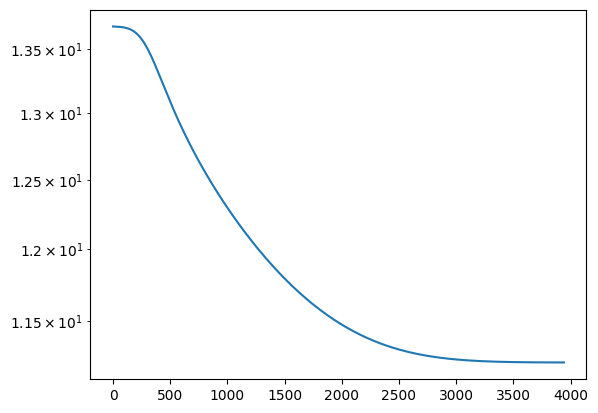

In [41]:
plt.plot(hist.history['loss'])
plt.yscale('log')

In [42]:
test_ds = create_dataset(cube, psf, rot_angles, table, window_size=window_size, batch_size=2000, repeat=1)

In [ ]:
pred, flux = model.predict(test_ds)

In [15]:
y_true = tf.concat([y['ids'] for x, y in test_ds], axis=0)

In [20]:
# import tensorflow as tf

# unique_ids, idx = tf.unique(y_true)  # Get unique values and indices

# output_pred = tf.dynamic_partition(pred, idx, tf.shape(unique_ids)[0])
# fluxes = tf.reduce_max(flux[-3], axis=[1,2,3])
# output_flux = tf.dynamic_partition(fluxes, idx, tf.shape(unique_ids)[0])

In [22]:
# flux_list = tf.reduce_max(flux, axis=[1,2,3])

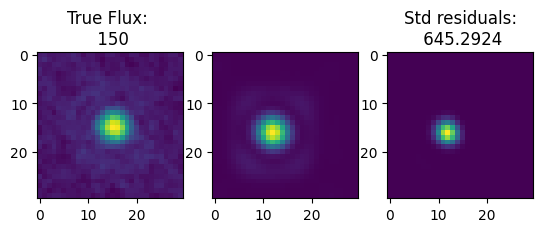

In [31]:
fig, axes = plt.subplots(1, 3)

for x, y in test_ds:
    n = 1

    win_0 = x['windows'][n]
    win_1 = pred[n]
    
    axes[0].imshow(win_0)
    axes[0].set_title('True Flux: \n 150')
    
    axes[1].imshow(win_1)
#     axes[1].set_title('Predicted Flux: \n {:.2f}'.format(flux_list[n]))
    
    residuals = tf.math.subtract(win_0, win_1)
    res_square = tf.pow(residuals, 2)
    axes[2].set_title('Std residuals:\n {:.4f}'.format(tf.math.reduce_std(res_square)))
    axes[2].imshow(res_square)
    
    break
    
plt.show()